In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_price=pd.read_csv("prices.csv")

In [3]:
df_price.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
df_small=df_price.loc[0:5000]

In [5]:
df_small['date'] = pd.to_datetime(df_small['date'])

F:\Examples\New folder\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
df_small.set_index('date',inplace=True)

## NORMALIZATION AND TEST TRAIN SPLIT

In [7]:
df_stock=df_small['close']

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_stc=scaler.fit_transform(np.array(df_stock).reshape(-1,1))

In [9]:
print(df_stc)

[[0.19895379]
 [0.18958262]
 [0.18153874]
 ...
 [0.00337427]
 [0.03569366]
 [0.03534184]]


In [10]:
##splitting dataset into train and test split
training_size=int(len(df_stc)*0.8)
test_size=len(df_stc)-training_size
train_data,test_data=df_stc[0:training_size,:],df_stc[training_size:len(df_stc),:1]

In [11]:
training_size,test_size

(4000, 1001)

In [12]:
train_data

array([[0.19895379],
       [0.18958262],
       [0.18153874],
       ...,
       [0.33262913],
       [0.04122682],
       [0.08622763]])

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
print(X_train.shape), print(y_train.shape)

(3899, 100)
(3899,)


(None, None)

### Here to make it a sequential data we have arranged the dataset in such a way that the price on the 4th day is a result of it's preceeding 3 says

In [16]:
print(X_test.shape), print(ytest.shape)

(900, 100)
(900,)


(None, None)

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## CREATING A STACKED LSTM MODEL

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
import tensorflow as tf

In [20]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
61/61 [==============================] - 14s 227ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 2/100
61/61 [==============================] - 10s 166ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 3/100
61/61 [==============================] - 10s 168ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 4/100
61/61 [==============================] - 10s 168ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 5/100
61/61 [==============================] - 10s 164ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 6/100
61/61 [==============================] - 11s 185ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 7/100
61/61 [==============================] - 11s 177ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 8/100
61/61 [==============================] - 11s 174ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 9/100
61/61 [==============================] - 11s 188ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 10/100
61/61 [==============================] - 10s 171ms/step - loss: 0.006

61/61 [==============================] - 10s 164ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 81/100
61/61 [==============================] - 10s 166ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 82/100
61/61 [==============================] - 10s 165ms/step - loss: 0.0012 - val_loss: 9.2951e-04
Epoch 83/100
61/61 [==============================] - 11s 182ms/step - loss: 9.6293e-04 - val_loss: 8.2945e-04
Epoch 84/100
61/61 [==============================] - 13s 210ms/step - loss: 9.0112e-04 - val_loss: 8.4888e-04
Epoch 85/100
61/61 [==============================] - 14s 223ms/step - loss: 8.6754e-04 - val_loss: 7.7690e-04
Epoch 86/100
61/61 [==============================] - 11s 185ms/step - loss: 9.8288e-04 - val_loss: 0.0012
Epoch 87/100
61/61 [==============================] - 12s 202ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 88/100
61/61 [==============================] - 10s 168ms/step - loss: 8.1147e-04 - val_loss: 7.5334e-04
Epoch 89/100
61/61 [==========================

## QUICK NOTE
### 1. Epoch: One Epoch is when an entire dataset is passed forward and backward through the neural network only ONCE.
### 2. Batch Size:Total number of training examples present in a single batch.

In [24]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [25]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

70.1393645994588

In [27]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

66.27209140262946

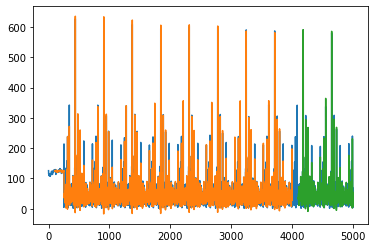

In [31]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df_stc)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_stc)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_stc)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_stc))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [32]:
len(test_data)

1001

In [33]:
1001-100

901

In [34]:
x_input=test_data[901:].reshape(1,-1)
x_input.shape

(1, 100)

In [35]:

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [36]:
temp_input

[0.06201614085728034,
 0.06914847539414636,
 0.0466158599446245,
 0.09487925755310517,
 0.056243104852020956,
 0.06804504542347405,
 0.07811986841108488,
 0.04261810718062476,
 0.04241021557404412,
 0.12932557056478222,
 0.05088586005581538,
 0.03188753464998038,
 0.08355707693011796,
 0.02894513255487487,
 0.06742136580619662,
 0.03433436252037574,
 0.11045525939833967,
 0.08523621436124952,
 0.03195158654667477,
 0.025043135401447796,
 0.03532585319399628,
 0.10823240287440115,
 0.055203643620760745,
 0.011849912728271274,
 0.02461135720487111,
 0.05475587203994716,
 0.09646244747224336,
 0.023715817241600948,
 0.023987677587593674,
 0.046967872716508416,
 0.0067325415095846235,
 0.06088072571731275,
 0.34160051263649976,
 0.04148269204065716,
 0.0875869268059084,
 0.06767723436713095,
 0.05680282212660032,
 0.04484096370456327,
 0.04655208790416863,
 0.06633392602140421,
 0.10525792925436105,
 0.03956367623447117,
 0.041994429162525826,
 0.05598723789026513,
 0.020309567024162645,
 

In [38]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.03460075]
101
1 day input [0.06914848 0.04661586 0.09487926 0.0562431  0.06804505 0.07811987
 0.04261811 0.04241022 0.12932557 0.05088586 0.03188753 0.08355708
 0.02894513 0.06742137 0.03433436 0.11045526 0.08523621 0.03195159
 0.02504314 0.03532585 0.1082324  0.05520364 0.01184991 0.02461136
 0.05475587 0.09646245 0.02371582 0.02398768 0.04696787 0.00673254
 0.06088073 0.34160051 0.04148269 0.08758693 0.06767723 0.05680282
 0.04484096 0.04655209 0.06633393 0.10525793 0.03956368 0.04199443
 0.05598724 0.02030957 0.04994234 0.08103037 0.06460681 0.04288997
 0.04701585 0.0332949  0.04124281 0.05907365 0.05715464 0.04791139
 0.07388205 0.0200537  0.0595694  0.10693707 0.0897459  0.06497462
 0.06838087 0.20178435 0.02864129 0.10655326 0.0582101  0.17106413
 0.1047302  0.12977333 0.06820497 0.02269236 0.01504827 0.12707072
 0.02619454 0.06179226 0.03369469 0.06641388 0.05907365 0.24923197
 0.09470335 0.02381177 0.0959667  0.06297565 0.04276203 0.06024105
 0.13177231 0.12131368 0.17480621

9 day output [[0.11783382]]
10 day input [0.05088586 0.03188753 0.08355708 0.02894513 0.06742137 0.03433436
 0.11045526 0.08523621 0.03195159 0.02504314 0.03532585 0.1082324
 0.05520364 0.01184991 0.02461136 0.05475587 0.09646245 0.02371582
 0.02398768 0.04696787 0.00673254 0.06088073 0.34160051 0.04148269
 0.08758693 0.06767723 0.05680282 0.04484096 0.04655209 0.06633393
 0.10525793 0.03956368 0.04199443 0.05598724 0.02030957 0.04994234
 0.08103037 0.06460681 0.04288997 0.04701585 0.0332949  0.04124281
 0.05907365 0.05715464 0.04791139 0.07388205 0.0200537  0.0595694
 0.10693707 0.0897459  0.06497462 0.06838087 0.20178435 0.02864129
 0.10655326 0.0582101  0.17106413 0.1047302  0.12977333 0.06820497
 0.02269236 0.01504827 0.12707072 0.02619454 0.06179226 0.03369469
 0.06641388 0.05907365 0.24923197 0.09470335 0.02381177 0.0959667
 0.06297565 0.04276203 0.06024105 0.13177231 0.12131368 0.17480621
 0.0745537  0.0860358  0.04493692 0.381532   0.0807905  0.0387321
 0.01309727 0.05797022 0.

17 day output [[0.15811367]]
18 day input [0.03195159 0.02504314 0.03532585 0.1082324  0.05520364 0.01184991
 0.02461136 0.05475587 0.09646245 0.02371582 0.02398768 0.04696787
 0.00673254 0.06088073 0.34160051 0.04148269 0.08758693 0.06767723
 0.05680282 0.04484096 0.04655209 0.06633393 0.10525793 0.03956368
 0.04199443 0.05598724 0.02030957 0.04994234 0.08103037 0.06460681
 0.04288997 0.04701585 0.0332949  0.04124281 0.05907365 0.05715464
 0.04791139 0.07388205 0.0200537  0.0595694  0.10693707 0.0897459
 0.06497462 0.06838087 0.20178435 0.02864129 0.10655326 0.0582101
 0.17106413 0.1047302  0.12977333 0.06820497 0.02269236 0.01504827
 0.12707072 0.02619454 0.06179226 0.03369469 0.06641388 0.05907365
 0.24923197 0.09470335 0.02381177 0.0959667  0.06297565 0.04276203
 0.06024105 0.13177231 0.12131368 0.17480621 0.0745537  0.0860358
 0.04493692 0.381532   0.0807905  0.0387321  0.01309727 0.05797022
 0.10890405 0.00337427 0.03569366 0.03534184 0.03460075 0.08343022
 0.07366078 0.04093158 

26 day output [[0.03113647]]
27 day input [0.02371582 0.02398768 0.04696787 0.00673254 0.06088073 0.34160051
 0.04148269 0.08758693 0.06767723 0.05680282 0.04484096 0.04655209
 0.06633393 0.10525793 0.03956368 0.04199443 0.05598724 0.02030957
 0.04994234 0.08103037 0.06460681 0.04288997 0.04701585 0.0332949
 0.04124281 0.05907365 0.05715464 0.04791139 0.07388205 0.0200537
 0.0595694  0.10693707 0.0897459  0.06497462 0.06838087 0.20178435
 0.02864129 0.10655326 0.0582101  0.17106413 0.1047302  0.12977333
 0.06820497 0.02269236 0.01504827 0.12707072 0.02619454 0.06179226
 0.03369469 0.06641388 0.05907365 0.24923197 0.09470335 0.02381177
 0.0959667  0.06297565 0.04276203 0.06024105 0.13177231 0.12131368
 0.17480621 0.0745537  0.0860358  0.04493692 0.381532   0.0807905
 0.0387321  0.01309727 0.05797022 0.10890405 0.00337427 0.03569366
 0.03534184 0.03460075 0.08343022 0.07366078 0.04093158 0.02827691
 0.03686078 0.05974205 0.09215523 0.12043066 0.11783382 0.08435263
 0.05824788 0.05545038 

In [39]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [40]:
len(df_stc)

5001

In [49]:
5001-100

4901

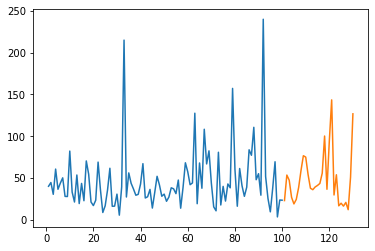

In [43]:
plt.plot(day_new,scaler.inverse_transform(df_stc[4901:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

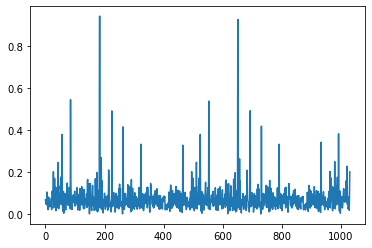

In [44]:
df3=df_stc.tolist()
df3.extend(lst_output)
plt.plot(df3[4000:])

In [45]:
df3=scaler.inverse_transform(df3).tolist()

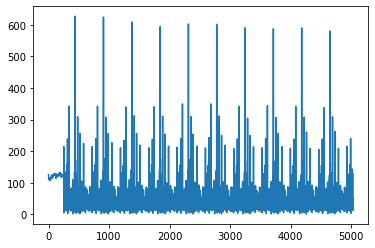

In [48]:
plt.plot(df3)